# 06 - Restart Wrappers & CMA-ES Variants
### [Last Update: March 2022][![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/evosax/blob/main/examples/06_restart_es.ipynb)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

!pip install -q evosax

## Restart Open-ES on CartPole when Fitness "Converges"
### Double Population Size Each Time!

In [2]:
import jax
import jax.numpy as jnp

from evosax import OpenES, ParameterReshaper, FitnessShaper, NetworkMapper
from evosax.utils import ESLog
from evosax.problems import GymFitness

rng = jax.random.PRNGKey(0)
network = NetworkMapper["MLP"](
    num_hidden_units=32,
    num_hidden_layers=2,
    num_output_units=2,
    hidden_activation="relu",
    output_activation="categorical",
)
pholder = jnp.zeros((4,))
params = network.init(
    rng,
    x=pholder,
    rng=rng,
)

param_reshaper = ParameterReshaper(params['params'])

ParameterReshaper: More than one device detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.


In [3]:
evaluator = GymFitness("CartPole-v1", num_env_steps=200, num_rollouts=16)
evaluator.set_apply_fn(param_reshaper.vmap_dict, network.apply)

GymFitness: More than one device detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.


In [4]:
from evosax.restarts import IPOP_Restarter

# Define a termination criterion (kwargs - fitness, state, params)
def std_criterion(fitness, state, params):
    """Restart strategy if fitness std across population is small."""
    return fitness.std() < 10

base_strategy = OpenES(popsize=20,
                       num_dims=param_reshaper.total_params,
                       opt_name="sgd")

strategy = IPOP_Restarter(base_strategy, stop_criteria=[std_criterion], strategy_kwargs={"opt_name": "sgd"})
es_params = strategy.default_params
es_params  # popsize_multiplier - controls increase at each restart

{'sigma_init': 0.04,
 'sigma_decay': 0.999,
 'sigma_limit': 0.01,
 'init_min': 0.0,
 'init_max': 0.0,
 'lrate_init': 0.01,
 'lrate_decay': 0.999,
 'lrate_limit': 0.001,
 'momentum': 0.9,
 'clip_min': -3.4028235e+38,
 'clip_max': 3.4028235e+38,
 'min_num_gens': 50,
 'min_fitness_spread': 1e-12,
 'popsize_multiplier': 2}

In [5]:
num_generations = 200
print_every_k_gens = 20

es_logging = ESLog(param_reshaper.total_params,
                   num_generations,
                   top_k=5,
                   maximize=True)
log = es_logging.initialize()

fit_shaper = FitnessShaper(centered_rank=True,
                           z_score=True,
                           w_decay=0.1,
                           maximize=True)

state = strategy.initialize(rng, es_params)

restart_gens = []

for gen in range(num_generations):
    rng, rng_init, rng_ask, rng_eval = jax.random.split(rng, 4)
    if state["restart_next"]:
        restart_gens.append(gen)
        print(f"--> Restarted Strategy: Gen {gen}")
        print_update = True
    else:
        print_update = False
    x, state = strategy.ask(rng_ask, state, es_params)
    if print_update:
        print(f"--> New Popsize: {state['active_popsize']}")
    reshaped_params = param_reshaper.reshape(x)
    fitness = evaluator.rollout(rng_eval, reshaped_params).mean(axis=1)
    fit_re = fit_shaper.apply(x, fitness)
    state = strategy.tell(x, fit_re, state, es_params)
    log = es_logging.update(log, x, fitness)
    
    if gen % print_every_k_gens == 0:
        print("Generation: ", gen, "Perf (Best): ", log["log_top_1"][gen], "Perf (Mean): ", fitness.mean())

/cognition/home/RobTLange/anaconda/envs/snippets/lib/python3.8/site-packages/jax/_src/dispatch.py:232: UserWarning: The jitted function reshape_network includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(
/cognition/home/RobTLange/anaconda/envs/snippets/lib/python3.8/site-packages/jax/_src/dispatch.py:232: UserWarning: The jitted function rollout includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


Generation:  0 Perf (Best):  21.875 Perf (Mean):  20.890625
Generation:  20 Perf (Best):  200.0 Perf (Mean):  200.0
Generation:  40 Perf (Best):  200.0 Perf (Mean):  197.24687
--> Restarted Strategy: Gen 50
--> New Popsize: 40
Generation:  60 Perf (Best):  200.0 Perf (Mean):  79.30312
Generation:  80 Perf (Best):  200.0 Perf (Mean):  174.93594
--> Restarted Strategy: Gen 100
--> New Popsize: 80
Generation:  100 Perf (Best):  200.0 Perf (Mean):  17.378906
Generation:  120 Perf (Best):  200.0 Perf (Mean):  200.0
Generation:  140 Perf (Best):  200.0 Perf (Mean):  200.0
--> Restarted Strategy: Gen 150
--> New Popsize: 160
Generation:  160 Perf (Best):  200.0 Perf (Mean):  61.57266
Generation:  180 Perf (Best):  200.0 Perf (Mean):  200.0


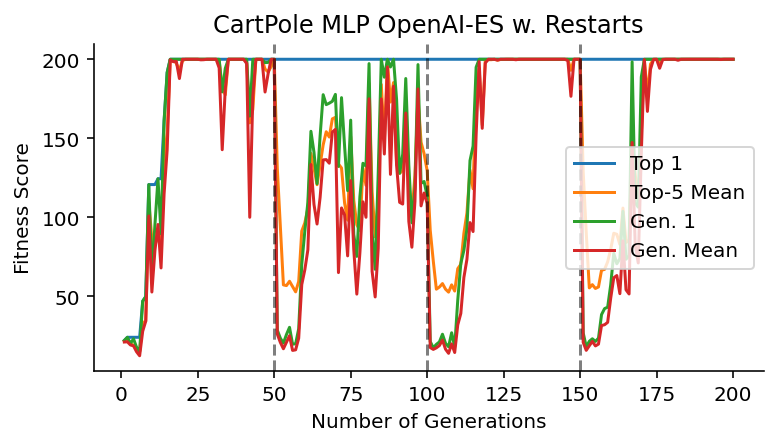

In [6]:
fig, ax = es_logging.plot(log, "CartPole MLP OpenAI-ES w. Restarts")
for i in restart_gens:
    ax.axvline(i, c="black", ls="--", alpha=0.5)

## BIPOP-CMA-ES

In [7]:
from evosax import BIPOP_CMA_ES

strategy = BIPOP_CMA_ES(popsize=100,
                        num_dims=param_reshaper.total_params,
                        elite_ratio=0.5)
es_params = strategy.default_params
es_params["min_fitness_spread"] = 1
es_params

{'mu_eff': DeviceArray(26.96665, dtype=float32),
 'c_1': DeviceArray(1.2144131e-06, dtype=float32),
 'c_mu': DeviceArray(3.0331765e-05, dtype=float32),
 'c_m': 1.0,
 'c_sigma': DeviceArray(0.02204519, dtype=float32),
 'd_sigma': DeviceArray(1.0220451, dtype=float32),
 'c_c': DeviceArray(0.00312667, dtype=float32),
 'chi_n': DeviceArray(35.798042, dtype=float32),
 'weights': DeviceArray([ 0.08235825,  0.06780273,  0.05928829,  0.05324719,
               0.04856136,  0.04473276,  0.04149572,  0.03869167,
               0.03621832,  0.03400584,  0.0320044 ,  0.03017723,
               0.0284964 ,  0.02694019,  0.0254914 ,  0.02413614,
               0.02286307,  0.02166279,  0.02052743,  0.01945031,
               0.01842575,  0.01744887,  0.01651542,  0.0156217 ,
               0.01476447,  0.01394087,  0.01314835,  0.01238466,
               0.01164778,  0.01093587,  0.01024731,  0.00958061,
               0.00893443,  0.00830755,  0.00769883,  0.00710726,
               0.00653191,  0.

In [8]:
# Use single device due to odd/even popsizes -> makes it hard to make sure even division
param_reshaper = ParameterReshaper(params['params'], n_devices=1)
evaluator = GymFitness("CartPole-v1", num_env_steps=200, num_rollouts=16, n_devices=1)
evaluator.set_apply_fn(param_reshaper.vmap_dict, network.apply)

In [9]:
num_generations = 600
print_every_k_gens = 20

es_logging = ESLog(param_reshaper.total_params,
                   num_generations,
                   top_k=5,
                   maximize=True)
log = es_logging.initialize()

fit_shaper = FitnessShaper(w_decay=0.1,
                           maximize=True)

state = strategy.initialize(rng, es_params)

restart_gens = []

for gen in range(num_generations):
    rng, rng_init, rng_ask, rng_eval = jax.random.split(rng, 4)
    if state["restart_next"]:
        restart_gens.append(gen)
        print(f"--> Restarted Strategy: Gen {gen}")
        print_update = True
    else:
        print_update = False
    x, state = strategy.ask(rng_ask, state, es_params)
    if print_update:
        print(f"--> New Popsize: {state['active_popsize']}")
    reshaped_params = param_reshaper.reshape(x)
    fitness = evaluator.rollout(rng_eval, reshaped_params).mean(axis=1)
    fit_re = fit_shaper.apply(x, fitness)
    state = strategy.tell(x, fit_re, state, es_params)
    log = es_logging.update(log, x, fitness)
    
    if gen % print_every_k_gens == 0:
        print("Generation: ", gen, "Perf (Best): ", log["log_top_1"][gen], "Perf (Mean): ", fitness.mean())

Generation:  0 Perf (Best):  24.1875 Perf (Mean):  21.789375
Generation:  20 Perf (Best):  29.5625 Perf (Mean):  20.15625
Generation:  40 Perf (Best):  29.5625 Perf (Mean):  21.512499
Generation:  60 Perf (Best):  31.5625 Perf (Mean):  17.129375
Generation:  80 Perf (Best):  33.75 Perf (Mean):  24.57625
Generation:  100 Perf (Best):  53.4375 Perf (Mean):  31.818748
Generation:  120 Perf (Best):  130.8125 Perf (Mean):  76.581245
Generation:  140 Perf (Best):  200.0 Perf (Mean):  171.45375
Generation:  160 Perf (Best):  200.0 Perf (Mean):  199.22499
--> Restarted Strategy: Gen 180
--> New Popsize: 200
Generation:  180 Perf (Best):  200.0 Perf (Mean):  19.42125
Generation:  200 Perf (Best):  200.0 Perf (Mean):  20.525936
Generation:  220 Perf (Best):  200.0 Perf (Mean):  20.189062
Generation:  240 Perf (Best):  200.0 Perf (Mean):  23.519999
Generation:  260 Perf (Best):  200.0 Perf (Mean):  21.384375
Generation:  280 Perf (Best):  200.0 Perf (Mean):  21.339375
Generation:  300 Perf (Best)

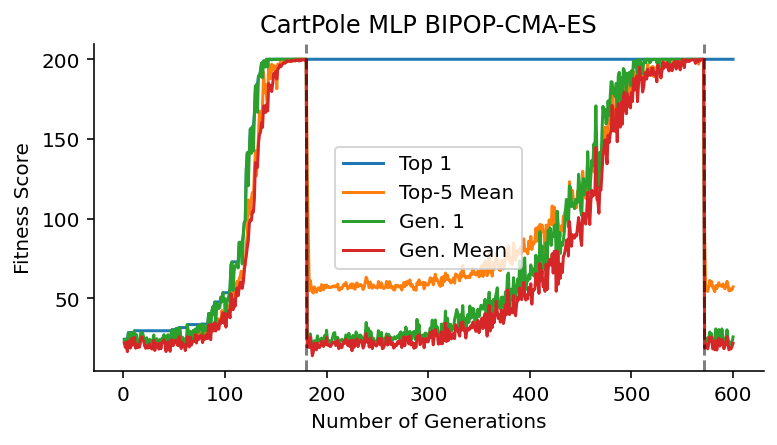

In [10]:
fig, ax = es_logging.plot(log, "CartPole MLP BIPOP-CMA-ES")
for i in restart_gens:
    ax.axvline(i, c="black", ls="--", alpha=0.5)